## Kaggle Playground S6E1 - Predicting Student Test Scores

This notebook performs **reproducible EDA, preprocessing, cross-validation, ensembling (blending), and submission file generation** in one place.

- **Target**: `exam_score`
- **Metric (local validation)**: RMSE (lower is better)

> Note: Kaggle Public/Private LB can differ from CV; final decisions are based on **OOF performance**.


In [ ]:
# Core libraries
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor

warnings.filterwarnings('ignore')

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Matplotlib Korean font settings (for local environments)
import platform
system_name = platform.system()
if system_name == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif system_name == 'Darwin':  # Mac
    plt.rc('font', family='AppleGothic')
else:  # Linux (Colab, Docker)
    plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

# Path resolution: try several options (including Kaggle)
def find_data_dir():
    """Find data directory that works both locally and on Kaggle."""
    # Kaggle competition dataset
    kaggle_dir = Path('/kaggle/input/playground-series-s6e1')
    if kaggle_dir.exists() and (kaggle_dir / 'train.csv').exists():
        return kaggle_dir

    possible_paths = [
        Path('Predicting Student Test Scores/data'),  # from project root
        Path('data'),  # data folder next to this notebook
        Path('../data'),  # parent-level data folder
        Path('.').resolve() / 'Predicting Student Test Scores' / 'data',  # absolute path guess
    ]

    for path in possible_paths:
        if path.exists() and (path / 'train.csv').exists():
            return path

    # As a last resort, walk up parents and try to find the data folder
    cwd = Path.cwd()
    for parent in [cwd] + list(cwd.parents):
        candidate = parent / 'Predicting Student Test Scores' / 'data'
        if candidate.exists() and (candidate / 'train.csv').exists():
            return candidate

    # Fallback (will raise an error later if files are missing)
    return Path('Predicting Student Test Scores/data')

DATA_DIR = find_data_dir()
TRAIN_PATH = DATA_DIR / 'train.csv'
TEST_PATH = DATA_DIR / 'test.csv'
SAMPLE_SUB_PATH = DATA_DIR / 'sample_submission.csv'

print(f'Current working directory: {Path.cwd()}')
print(f'Data directory: {DATA_DIR.resolve()}')
print(f'TRAIN path exists: {TRAIN_PATH.exists()}')
TRAIN_PATH, TEST_PATH, SAMPLE_SUB_PATH

In [ ]:
# Data loading (wrap in try-except for robustness)
try:
    train_df = pd.read_csv(TRAIN_PATH)
    test_df = pd.read_csv(TEST_PATH)
    sample_sub = pd.read_csv(SAMPLE_SUB_PATH)
except FileNotFoundError as e:
    raise FileNotFoundError(
        f"File not found. Please check paths.\n- TRAIN: {TRAIN_PATH}\n- TEST: {TEST_PATH}\n- SAMPLE: {SAMPLE_SUB_PATH}"
    ) from e

print('train:', train_df.shape, 'test:', test_df.shape)
display(train_df.head())
display(test_df.head())
display(sample_sub.head())

train: (630000, 13) test: (270000, 12)


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,easy
1,630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,low,easy
2,630002,24,female,b.tech,6.60,98.5,yes,6.2,good,group study,medium,moderate
3,630003,24,male,diploma,3.03,66.3,yes,5.7,average,mixed,medium,moderate
4,630004,20,female,b.tech,2.03,42.4,yes,9.2,average,coaching,low,moderate


,id,exam_score
0,630000,0
1,630001,0
2,630002,0
3,630003,0
4,630004,0


--- Dtypes ---


id                    int64
age                   int64
gender               object
course               object
study_hours         float64
class_attendance    float64
internet_access      object
sleep_hours         float64
sleep_quality        object
study_method         object
facility_rating      object
exam_difficulty      object
exam_score          float64
dtype: object

--- Missing values (train) ---


,missing_rate
id,0.0
age,0.0
gender,0.0
course,0.0
study_hours,0.0
class_attendance,0.0
internet_access,0.0
sleep_hours,0.0
sleep_quality,0.0
study_method,0.0


--- Missing values (test) ---


,missing_rate
id,0.0
age,0.0
gender,0.0
course,0.0
study_hours,0.0
class_attendance,0.0
internet_access,0.0
sleep_hours,0.0
sleep_quality,0.0
study_method,0.0


--- Duplicates ---
train duplicate rows: 0
test duplicate rows: 0


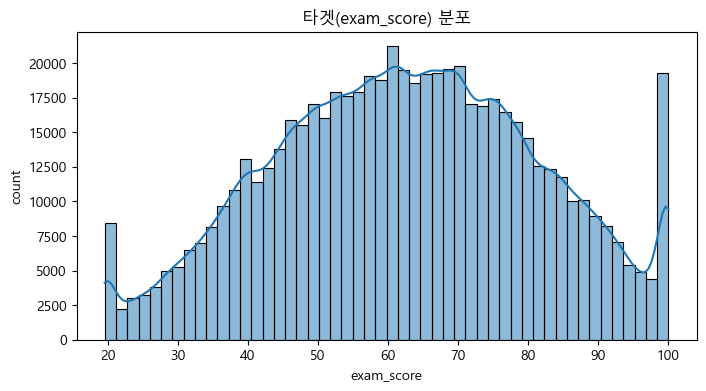

In [ ]:
# Basic data quality checks (missing/duplicates/dtypes)
TARGET_COL = 'exam_score'
ID_COL = 'id'

assert TARGET_COL in train_df.columns, 'Target column is missing in train.'
assert TARGET_COL not in test_df.columns, 'Target column is present in test (data leakage)!'

print('--- Dtypes ---')
display(train_df.dtypes)

print('--- Missing values (train) ---')
display(train_df.isna().mean().sort_values(ascending=False).to_frame('missing_rate'))

print('--- Missing values (test) ---')
display(test_df.isna().mean().sort_values(ascending=False).to_frame('missing_rate'))

print('--- Duplicates ---')
print('train duplicate rows:', train_df.duplicated().sum())
print('test duplicate rows:', test_df.duplicated().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(train_df[TARGET_COL], bins=50, kde=True)
plt.title('Target (exam_score) distribution')
plt.xlabel('exam_score')
plt.ylabel('count')
plt.show()

numeric_cols: ['id', 'age', 'study_hours', 'class_attendance', 'sleep_hours']
categorical_cols: ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']

--- Numeric summary ---


,count,mean,std,min,25%,50%,75%,max
id,630000.0,314999.500000,181865.479132,0.000,157499.75,314999.5,472499.25,629999.00
age,630000.0,20.545821,2.260238,17.000,19.00,21.0,23.00,24.00
study_hours,630000.0,4.002337,2.359880,0.080,1.97,4.0,6.05,7.91
class_attendance,630000.0,71.987261,17.430098,40.600,57.00,72.6,87.20,99.40
sleep_hours,630000.0,7.072758,1.744811,4.100,5.60,7.1,8.60,9.90
exam_score,630000.0,62.506672,18.916884,19.599,48.80,62.6,76.30,100.00



--- Categorical cardinality ---


,n_unique
course,7
study_method,5
gender,3
facility_rating,3
sleep_quality,3
exam_difficulty,3
internet_access,2


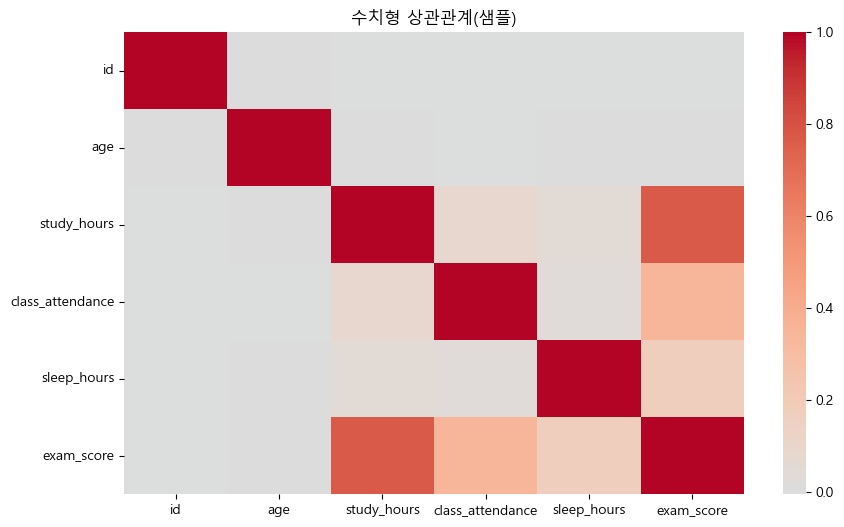

In [ ]:
# Quick EDA: numeric / categorical summaries
feature_cols = [c for c in train_df.columns if c not in [TARGET_COL]]

X = train_df[feature_cols].copy()
y = train_df[TARGET_COL].copy()
X_test = test_df[feature_cols].copy()

# Split column types
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = [c for c in X.columns if c not in categorical_cols]

print('numeric_cols:', numeric_cols)
print('categorical_cols:', categorical_cols)

print('\n--- Numeric summary ---')
display(train_df[numeric_cols + [TARGET_COL]].describe().T)

print('\n--- Categorical cardinality ---')
display(train_df[categorical_cols].nunique().sort_values(ascending=False).to_frame('n_unique'))

# Correlation (numeric only) - use a sample for speed
sample_df = train_df.sample(n=min(50_000, len(train_df)), random_state=RANDOM_STATE)
plt.figure(figsize=(10, 6))
sns.heatmap(sample_df[numeric_cols + [TARGET_COL]].corr(), annot=False, cmap='coolwarm', center=0)
plt.title('Numeric correlations (sample)')
plt.show()

In [ ]:
# Preprocessing pipelines
# - Linear model: OneHotEncoder + StandardScaler(with_mean=False) on sparse matrix
# - Tree model: OrdinalEncoder(unknown=-1) for fast and memory-efficient handling

numeric_transformer_basic = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
    ]
)

categorical_transformer_ohe = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True)),
    ]
)

categorical_transformer_ord = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ]
)

preprocess_ohe = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_basic, numeric_cols),
        ('cat', categorical_transformer_ohe, categorical_cols),
    ],
    remainder='drop',
    sparse_threshold=0.3,
)

preprocess_ord = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_basic, numeric_cols),
        ('cat', categorical_transformer_ord, categorical_cols),
    ],
    remainder='drop',
)

# Model definitions
ridge_model = Ridge(alpha=2.0, random_state=RANDOM_STATE)

hgb_model = HistGradientBoostingRegressor(
    loss='squared_error',
    learning_rate=0.06,
    max_depth=None,
    max_leaf_nodes=63,
    min_samples_leaf=40,
    l2_regularization=0.0,
    max_bins=255,
    random_state=RANDOM_STATE,
)

model_ridge = Pipeline(
    steps=[
        ('preprocess', preprocess_ohe),
        ('scaler', StandardScaler(with_mean=False)),
        ('model', ridge_model),
    ]
)

model_hgb = Pipeline(
    steps=[
        ('preprocess', preprocess_ord),
        ('model', hgb_model),
    ]
)

model_ridge, model_hgb

(Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='median'))]),
                                                   ['id', 'age', 'study_hours',
                                                    'class_attendance',
                                                    'sleep_hours']),
                                                  ('cat',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('onehot',
                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                   ['gender', 'course

In [ ]:
# CV utilities

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


def train_cv_oof(model, X, y, X_test, n_splits=5, random_state=RANDOM_STATE):
    """Generate OOF + test predictions with KFold.

    - OOF is the core ingredient for blending/stacking
    - test_pred is the fold-wise mean prediction
    """
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    oof_pred = np.zeros(len(X), dtype=np.float64)
    test_pred = np.zeros(len(X_test), dtype=np.float64)
    scores = []

    for fold, (tr_idx, va_idx) in enumerate(cv.split(X), start=1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        # Train model
        model.fit(X_tr, y_tr)

        # Validation prediction
        va_pred = model.predict(X_va)
        oof_pred[va_idx] = va_pred

        fold_rmse = rmse(y_va, va_pred)
        scores.append(fold_rmse)
        print(f'[fold {fold}] RMSE: {fold_rmse:.5f}')

        # Accumulate test predictions
        test_pred += model.predict(X_test) / n_splits

    print(f'CV RMSE mean: {np.mean(scores):.5f}  std: {np.std(scores):.5f}')
    print(f'OOF RMSE: {rmse(y, oof_pred):.5f}')
    return oof_pred, test_pred, scores


In [ ]:
# Model training (generate OOF predictions)
print('=== Ridge(OHE) ===')
ridge_oof, ridge_test, ridge_scores = train_cv_oof(model_ridge, X, y, X_test, n_splits=5)

print('\n=== HistGB(Ordinal) ===')
hgb_oof, hgb_test, hgb_scores = train_cv_oof(model_hgb, X, y, X_test, n_splits=5)

# Performance comparison
results_df = pd.DataFrame({
    'model': ['Ridge(OHE)', 'HistGB(Ordinal)'],
    'oof_rmse': [rmse(y, ridge_oof), rmse(y, hgb_oof)],
})
display(results_df.sort_values('oof_rmse'))

=== Ridge(OHE) ===
[fold 1] RMSE: 8.88649
[fold 2] RMSE: 8.89207
[fold 3] RMSE: 8.88516
[fold 4] RMSE: 8.89747
[fold 5] RMSE: 8.91300
CV RMSE mean: 8.89484  std: 0.01008
OOF RMSE: 8.89484

=== HistGB(Ordinal) ===
[fold 1] RMSE: 8.80456
[fold 2] RMSE: 8.81923
[fold 3] RMSE: 8.80663
[fold 4] RMSE: 8.82413
[fold 5] RMSE: 8.84611
CV RMSE mean: 8.82013  std: 0.01495
OOF RMSE: 8.82015


,model,oof_rmse
1,HistGB(Ordinal),8.820146
0,Ridge(OHE),8.894843


Optimal weight for Ridge(OHE): 0.1176  (HistGB weight: 0.8824)
Ridge OOF RMSE: 8.894842575737645
HistGB OOF RMSE: 8.820145780247005
Blend OOF RMSE: 8.81878857024964


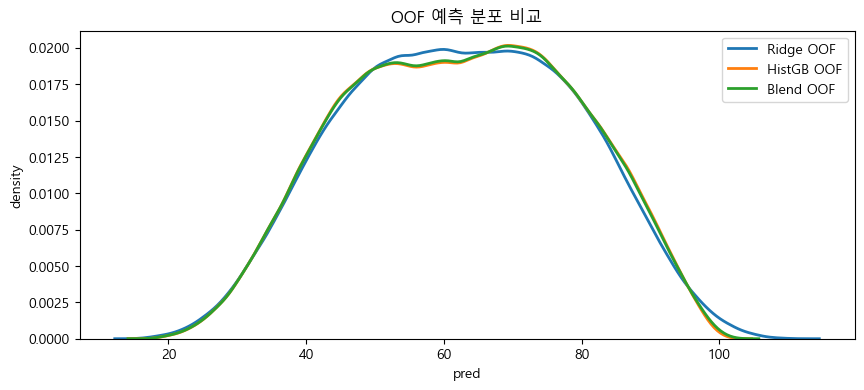

In [ ]:
# Optimal OOF-based blending (2 models)
# Solve for weight w that minimizes MSE:
# pred = w * pred_a + (1-w) * pred_b

def optimal_blend_weight(y_true, pred_a, pred_b):
    diff = pred_a - pred_b
    denom = np.dot(diff, diff)
    if denom == 0:
        return 0.5

    w = np.dot((y_true - pred_b), diff) / denom
    # Clip to [0,1] to avoid instability / overfitting
    return float(np.clip(w, 0.0, 1.0))

w_ridge = optimal_blend_weight(y.values, ridge_oof, hgb_oof)
print(f'Optimal weight for Ridge(OHE): {w_ridge:.4f}  (HistGB weight: {1-w_ridge:.4f})')

blend_oof = w_ridge * ridge_oof + (1 - w_ridge) * hgb_oof
blend_test = w_ridge * ridge_test + (1 - w_ridge) * hgb_test

print('Ridge OOF RMSE:', rmse(y, ridge_oof))
print('HistGB OOF RMSE:', rmse(y, hgb_oof))
print('Blend OOF RMSE:', rmse(y, blend_oof))

# Sanity check: OOF prediction distributions
plt.figure(figsize=(10, 4))
sns.kdeplot(ridge_oof, label='Ridge OOF', lw=2)
sns.kdeplot(hgb_oof, label='HistGB OOF', lw=2)
sns.kdeplot(blend_oof, label='Blend OOF', lw=2)
plt.title('OOF prediction distribution comparison')
plt.xlabel('pred')
plt.ylabel('density')
plt.legend()
plt.show()

In [ ]:
# Create submission file
sub = sample_sub.copy()

# Trust sample_submission column name (this may differ by competition)
pred_col = [c for c in sub.columns if c != ID_COL]
assert len(pred_col) == 1, f'sample_submission must have exactly 1 prediction column: {pred_col}'
pred_col = pred_col[0]

sub[pred_col] = blend_test

# Save next to the notebook / working directory (Kaggle-friendly)
out_path = Path('submission.csv')
sub.to_csv(out_path, index=False)

print('saved:', out_path.resolve())
display(sub.head())

# Quick check: id duplicates / shape
print('id duplicates in submission:', sub[ID_COL].duplicated().sum())
print('submission shape:', sub.shape)

saved: C:\Users\Henry\Kaggle\Kaggle\Predicting Student Test Scores\submission.csv


,id,exam_score
0,630000,72.419679
1,630001,69.484177
2,630002,87.519324
3,630003,54.922087
4,630004,47.644099


id duplicates in submission: 0
submission shape: (270000, 2)


## (Optional) Streamlit EDA dashboard

If you want, you can build a simple Streamlit app to explore feature distributions, missingness, and correlations interactively.

- Example file: `Predicting Student Test Scores/streamlit_app.py`
- Run: `streamlit run "Predicting Student Test Scores/streamlit_app.py"`


## Notebook changes for Kaggle environment

- Converted all Korean comments, messages, and markdown to English while keeping the original logic unchanged.
- Updated data path resolution to automatically use `/kaggle/input/playground-series-s6e1` when running on Kaggle, with local fallbacks.
- Adjusted submission saving to write `submission.csv` to the working directory (Kaggle-friendly) instead of a local project path.
- Left model, preprocessing, and CV logic as-is so that local CV/OOF behavior matches the original notebook.